# Final project
**BIOENG 145, SP2021, Prof. Liana Lareau**

May 14, 2021

Name: Martin Kim

SID: 3034222416

## Setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# Part 1 dependencies
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import random_projection
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split as split
tfd = tfp.distributions
tfpl = tfp.layers
keras = tf.keras
layers = tf.keras.layers

# Part 2 dependencies
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from tabulate import tabulate

In [2]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")
sns.set_theme()

## Part 0: Exploratory data analysis & preprocessing

#### 0.1: Visualizing the tables

In [3]:
labels_pd.head()

,index,bulk_labels
0,AAAGCCTGGCTAAC-1,CD14+ Monocyte
1,AAATTCGATGCACA-1,Dendritic
2,AACACGTGGTCTTT-1,CD56+ NK
3,AAGTGCACGTGCTA-1,CD4+/CD25 T Reg
4,ACACGAACGGAGTG-1,Dendritic


In [4]:
counts_pd.head()

,Unnamed: 0,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,NECAP2,HP1BP3,C1QA,C1QB,HNRNPR,GALE,STMN1,CD52,FGR,ATPIF1,SESN2,EIF3I,LCK,MARCKSL1,SFPQ,PSMB2,MEAF6,NDUFS5,CAP1,SMAP2,C1orf228,PRDX1,TMEM69,SCP2,MAGOH,JAK1,CCBL2,GBP2,CD53,...,FPR1,ZNF600,ZNF524,CTD-3138B18.5,ATP6V1E1,BID,MRPL40,UFD1L,COMT,DGCR6L,SDF2L1,IGLL5,IGLL1,CHCHD10,SMARCB1,MIF,ASCC2,PIK3IP1,HMOX1,EIF3D,IL2RB,LGALS2,EIF3L,ADSL,RBX1,TTC38,TYMP,CCT8,SOD1,PAXBP1,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,-0.525,1.804,0.578,-0.198,1.266,-0.192,-0.307,0.048,-0.606,0.478,-0.07,-0.864,-0.534,-0.504,-0.509,-0.727,-0.646,0.336,-0.017,4.381,-0.251,0.235,-0.252,-0.701,-0.537,-0.684,-0.244,-0.421,0.575,...,-0.27,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,0.697,-0.133,-0.062,1.777,0.948,0.436,-0.345,-0.418,0.652,0.351,-0.196,-0.413,-0.323,-0.491,-0.719,-0.205,-0.092,-0.694,-0.070,-0.116,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,1.287,-0.420,0.954,2.367,1.170,-0.192,-0.307,0.266,0.629,-0.802,-0.07,-0.864,-0.534,0.873,-0.509,0.645,-0.646,0.274,0.856,1.845,-0.251,-0.796,-0.252,-0.701,1.581,-0.684,-0.244,-0.421,-0.282,...,-0.27,-0.109,-0.402,-0.122,-0.583,2.992,1.327,-0.582,0.991,-0.507,0.636,-0.133,-0.062,-0.687,-0.497,0.373,-0.345,-0.418,-0.366,1.496,-0.196,-0.413,0.478,-0.491,-0.719,-0.205,1.089,-0.694,-0.120,-0.116,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,-0.525,1.258,-0.310,-0.198,-0.602,-0.192,-0.307,-0.462,1.358,-0.802,-0.07,0.205,-0.534,-0.504,-0.509,0.364,-0.646,-0.881,-0.256,-0.445,-0.251,-0.796,-0.252,0.480,2.831,1.528,-0.244,0.816,-0.440,...,-0.27,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,-0.782,-0.345,-0.418,-0.366,0.037,5.397,-0.413,0.131,1.310,-0.719,-0.205,-0.733,1.747,0.428,-0.116,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,-0.525,9.900,-0.310,-0.198,1.565,-0.192,2.270,1.258,-0.606,-0.802,-0.07,-0.864,0.741,-0.504,2.193,2.630,1.627,-0.881,-0.990,-0.445,-0.251,-0.796,-0.252,1.114,-0.537,-0.684,-0.244,1.481,2.728,...,-0.27,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,-0.782,-0.345,-0.418,-0.366,2.036,-0.196,-0.413,-0.180,-0.491,-0.719,-0.205,-0.733,-0.694,1.221,-0.116,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,-0.525,1.046,-0.310,-0.198,0.630,-0.192,-0.307,-0.546,1.110,1.730,-0.07,1.005,-0.534,-0.504,-0.509,-0.727,-0.646,-0.881,0.293,-0.445,-0.251,-0.796,-0.252,1.363,2.407,0.283,-0.244,-0.421,-0.518,...,-0.27,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,0.824,-0.345,-0.418,0.306,-0.926,-0.196,3.847,1.138,-0.491,0.213,-0.205,-0.310,-0.694,-1.048,-0.116,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490


#### 0.2: Visualize first 100 genes

In [5]:
genes = list(counts_pd.columns)[1:]
barcodes = list(counts_pd["Unnamed: 0"])
unique_labels = labels_pd.bulk_labels.unique()
encode = {}
for i, l in enumerate(unique_labels):
    encode[l] = i

counts = counts_pd.to_numpy()
labels = labels_pd.to_numpy()[:, 1]
X = counts[:, 1:].astype(np.float64)
y = [encode[l] for l in labels]
num_samples, num_genes = X.shape

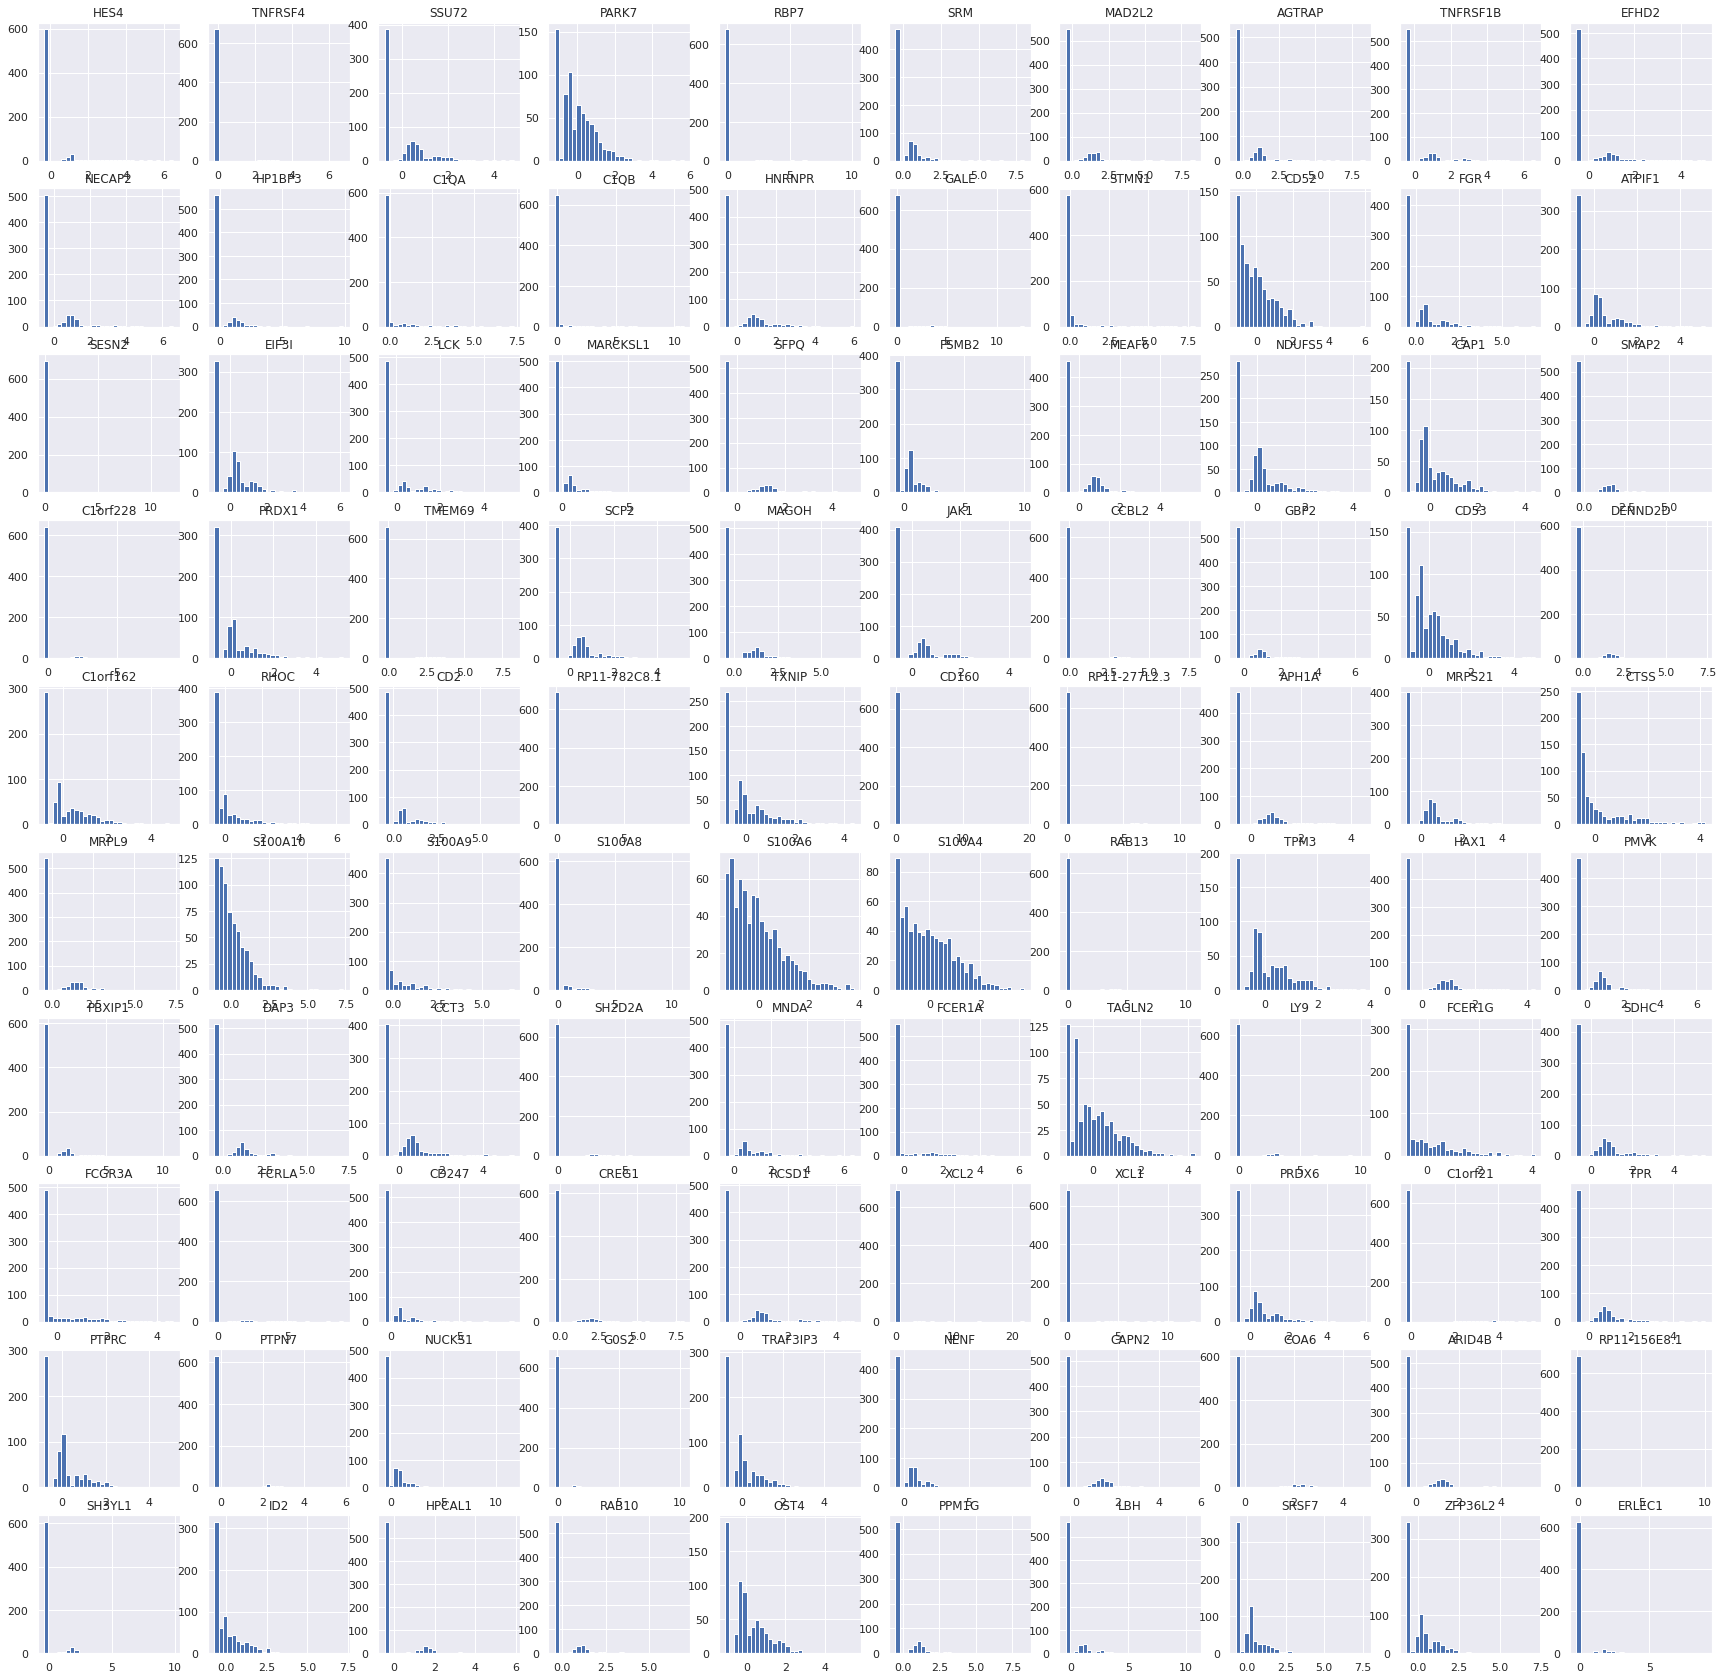

In [6]:
fig, ax = plt.subplots(10, 10, figsize=(30, 30))
for i in range(100):
    ax[i//10, i%10].hist(counts_pd.iloc[:,i+1], bins=30)
    ax[i//10, i%10].set_title(genes[i])

#### 0.3: Visualize the correlation between gene counts

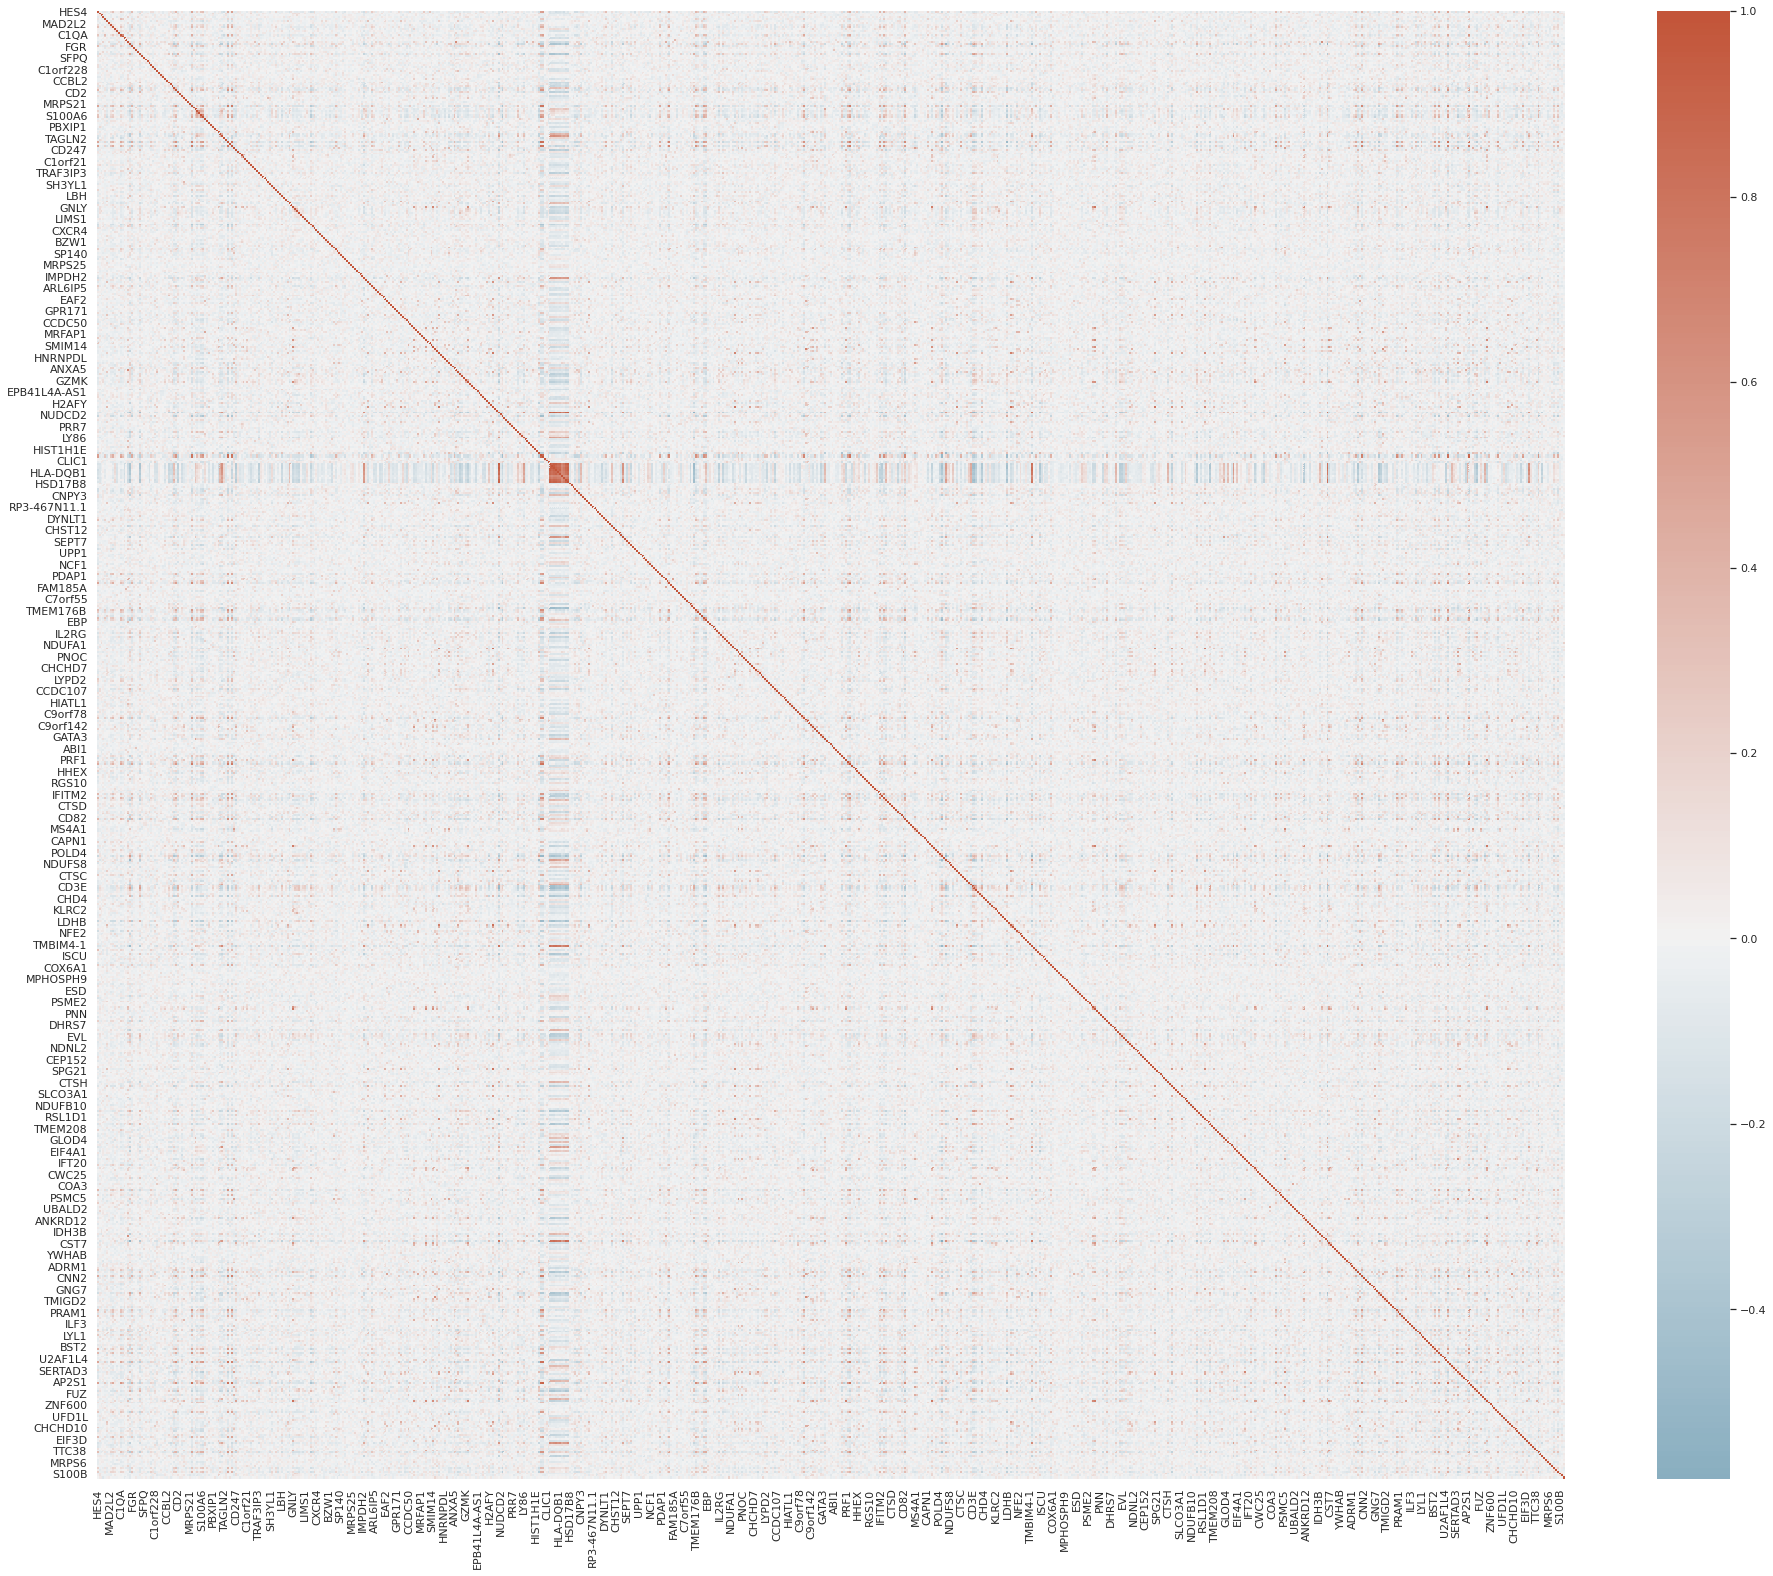

In [7]:
corr = counts_pd.corr()

f, ax = plt.subplots(figsize=(33, 27))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, square=True)

## Part 1: Autoencoder

In [8]:
# Check that we are using GPU for the runtime
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


### 1.1: Building a variational autoencoder

In [9]:
class Autoencoder(keras.Model):
    """
    Initializes a variational autoencoder with the following parameters:
    Parameters:
    - input_size: size of individial observations
    - latent_dim: size of the latent space
    - beta: reguarlization term for KL divergence
    """
    def __init__(self, input_size, latent_dim=32, beta=1):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta

        self.encoder = self.build_encoder(input_size)
        self.mean = keras.Sequential([layers.Dense(latent_dim, name="mean")])
        self.log_var = keras.Sequential([layers.Dense(latent_dim, name="log_var", activation='softplus')])
        self.decoder = self.build_decoder(input_size)

        self.loss_tracker = keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [
            self.loss_tracker
        ]

    """
    Helper function for adding dense layers to a NN.
    Parameters:
    - model: the Keras neural network
    - size: input size of the dense layer
    - drop: if not False, must be a number in (0, 1) specifying the dropout rate 
    - l: multiplier for l1-regularization
    """
    def add_dense(self, m, size, activation='relu', drop=False, l=0.001):
        m.add(layers.Dense(size, activation=activation, activity_regularizer=keras.regularizers.L1(l1=l)))
        if drop:
            m.add(layers.Dropout(drop))

    """
    Builds the encoder portion of the autoencoder.
    Parameters:
    - input_size: dimensions of the initial input
    - latent_dim: size of the latent space, the output of the last layer
    """
    def build_encoder(self, input_size):
        e = keras.Sequential([layers.Input(shape=(input_size,))])
        e.add(layers.Flatten())
        e.add(keras.layers.GaussianNoise(1))
        self.add_dense(e, input_size)
        self.add_dense(e, 256, drop=0.4)
        self.add_dense(e, 128, drop=0.3)
        self.add_dense(e, 64, drop=0.2)
        return e
    
    """
    Bulds the decoder portion of the autoencoder.
    Parameters:
    - output_size: dimensions of the output 
    - latent_dim: size of the latent space 
    """
    def build_decoder(self, output_size):
        d = keras.Sequential([layers.Input(shape=(self.latent_dim,))])
        self.add_dense(d, self.latent_dim)
        self.add_dense(d, 64, drop=0.2)
        self.add_dense(d, 128, drop=0.3)
        self.add_dense(d, 256, drop=0.4)
        self.add_dense(d, output_size)
        return d

    """
    Samples from a multivariate normal distribution given by 
    mean vector mu and covariance matrix with diagonal entries
    specified by log_sigma.
    """
    def sample(self, mu, log_sigma):
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * log_sigma) * epsilon

    """
    Computes the reconstruction and KL divergence loss.
    """
    def full_loss(self, x_true, x_pred, mu, log_sigma):
        #cross_ent = keras.losses.binary_crossentropy(x_true, x_pred, from_logits=True)
        #cross_ent = tf.reduce_sum(cross_ent, axis=-1)
        kl = -0.5*tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=-1)
        return tf.reduce_mean(self.beta*kl + keras.metrics.MSE(x_true, x_pred)) 

    """
    Forward pass of the neural network.
    """
    @tf.function
    def call(self, x):
        e = self.encoder(x)
        mu = self.mean(e)
        log_sigma = self.log_var(e)
        z = self.sample(mu, log_sigma)
        return self.decoder(z), mu, log_sigma, z

    """
    Custom training function to implement the non-standard loss.
    """
    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            x_hat, mu, log_sigma, z = self.call(data)
            loss = self.full_loss(data, x_hat, mu, log_sigma)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

### 1.2: Training the model and hyperparameter search

In [10]:
# Train and validation split
X_train, X_val, y_train, y_val = split(X, y, test_size=0.2, random_state=145)

We are searching over the following hyperparameters for our model:
- DIMS: dimensions of the latent space
- BETAS: regularization constants for KL divergence

In [11]:
# Hyperparameters to optimize over
# DIMS: the dimension of the latent space
# BETAS: the regularization term for KL divergence
DIMS = [2, 8, 16, 32, 48, 64]
BETAS = [0.001, 0.01, 0.1, 0, 1, 10]
PARAMS = np.array(np.meshgrid(DIMS, BETAS)).T.reshape(-1, 2)

In [12]:
train_losses = []
val_losses = []
val_losses_mse = []

for i, param in enumerate(PARAMS):
    dim, beta = param
    dim = round(dim)
    print("Training an autoencoder with dim = {} and beta = {}".format(dim, beta))
    vae = Autoencoder(num_genes, latent_dim=dim, beta=beta)
    vae.compile(optimizer='adam')
    loss_train = vae.fit(X_train, batch_size=140, epochs=20, verbose=0)
    train_losses.append(loss_train.history['loss'][-1])

    x_hat, mu, log_sigma, z = vae.predict(X_val)
    loss_val = vae.full_loss(X_val, x_hat, mu, log_sigma)
    loss_val = loss_val.numpy()
    val_losses.append(loss_val)

    loss_mse = keras.losses.MSE(X_val, x_hat)
    loss_mse = np.mean(loss_mse.numpy())
    val_losses_mse.append(loss_mse)

    print("Validation loss (same metric as training): {}".format(loss_val))
    print("Validation loss (MSE): {}".format(loss_mse))

Training an autoencoder with dim = 2 and beta = 0.001
Validation loss (same metric as training): 1.023852825164795
Validation loss (MSE): 1.0211083889007568
Training an autoencoder with dim = 2 and beta = 0.01
Validation loss (same metric as training): 1.0317126512527466
Validation loss (MSE): 1.0316394567489624
Training an autoencoder with dim = 2 and beta = 0.1
Validation loss (same metric as training): 1.0325876474380493
Validation loss (MSE): 1.0316907167434692
Training an autoencoder with dim = 2 and beta = 0.0
Validation loss (same metric as training): 1.0041192770004272
Validation loss (MSE): 1.0041192770004272
Training an autoencoder with dim = 2 and beta = 1.0
Validation loss (same metric as training): 1.0389471054077148
Validation loss (MSE): 1.0315399169921875
Training an autoencoder with dim = 2 and beta = 10.0
Validation loss (same metric as training): 1.1013747453689575
Validation loss (MSE): 1.0315746068954468
Training an autoencoder with dim = 8 and beta = 0.001
Validat

In [13]:
# Determine best parameters
val_losses_mse = np.array(val_losses_mse)
best_idx = np.argmin(val_losses_mse)
dim = round(PARAMS[best_idx][0])
beta = PARAMS[best_idx][1]
print("Best parameters: dim = {}, beta = {}".format(dim, beta))

Best parameters: dim = 48, beta = 0.0


### 1.3: Evaluating the model

#### 1.3.1: PCA

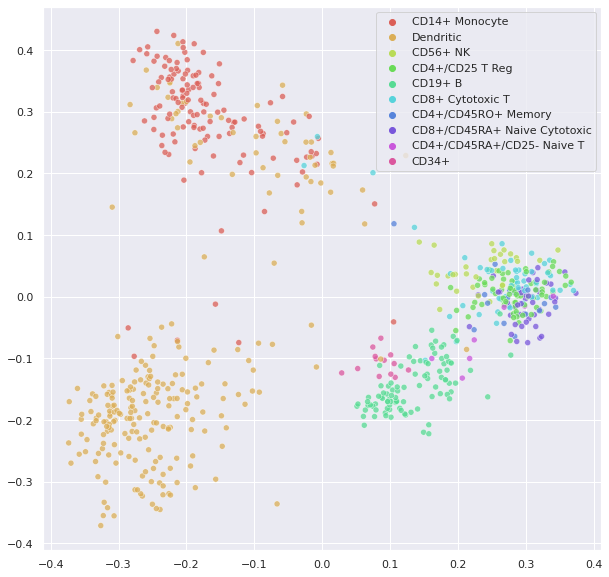

In [14]:
X_norm = normalize(X)
X_pca = PCA(n_components=2).fit_transform(X_norm)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", len(unique_labels)),
    legend='full',
    alpha=0.75
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_labels, loc='upper right')

#### 1.3.2: tSNE

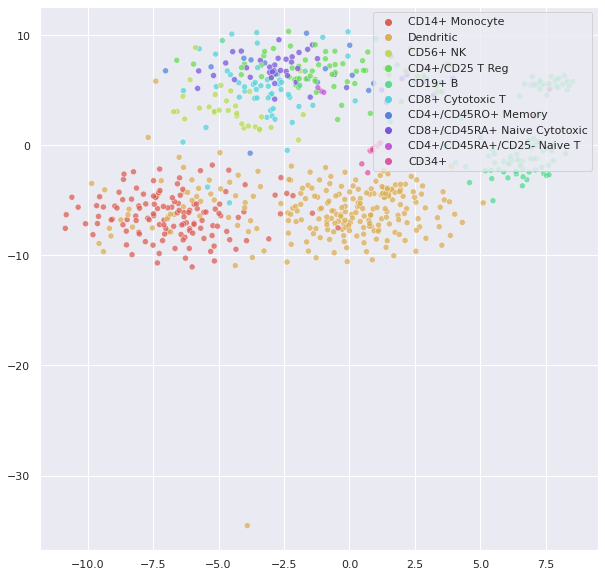

In [15]:
X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(X)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", len(unique_labels)),
    legend='full',
    alpha=0.75
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_labels, loc='upper right')

#### 1.3.3: Random projections

##### 1.3.3.1: Sparse random projection

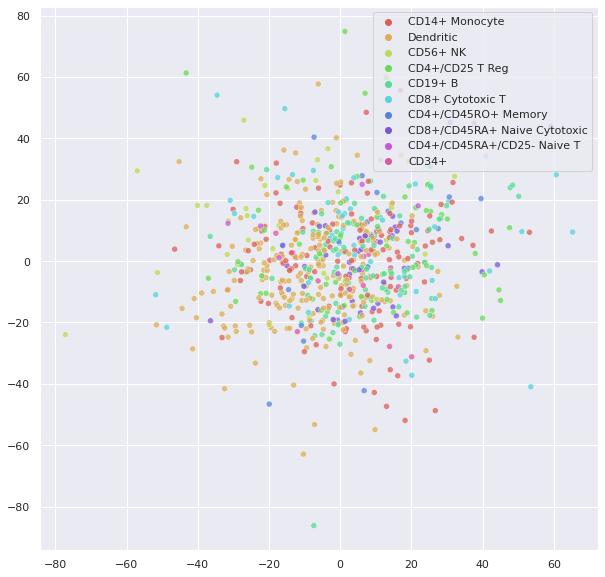

In [16]:
X_sparse = random_projection.SparseRandomProjection(n_components=2).fit_transform(X)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    x=X_sparse[:,0], y=X_sparse[:,1],
    hue=y,
    palette=sns.color_palette("hls", len(unique_labels)),
    legend='full',
    alpha=0.75
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_labels, loc='upper right')

##### 1.3.3.2: Gaussian random projection

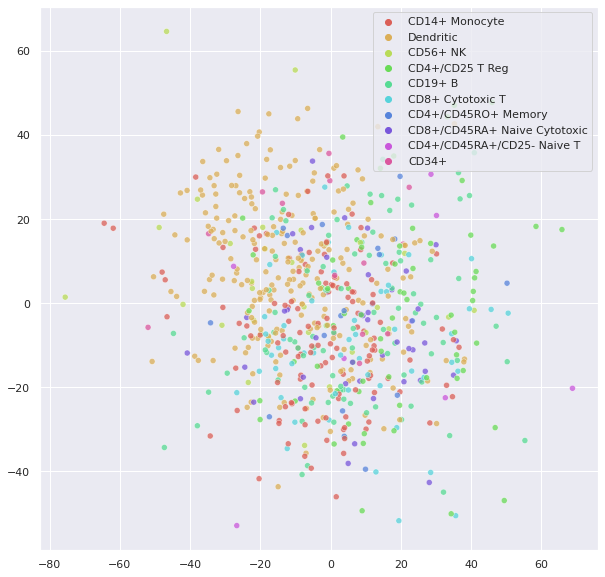

In [17]:
X_gauss = random_projection.GaussianRandomProjection(n_components=2).fit_transform(X)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    x=X_gauss[:,0], y=X_gauss[:,1],
    hue=y,
    palette=sns.color_palette("hls", len(unique_labels)),
    legend='full',
    alpha=0.75
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_labels, loc='upper right')

#### 1.3.4: Autoencoder

##### 1.3.4.1: Autoencoder on best parameters

In [18]:
# Autoencoder latent space + PCA on best determined parameters
vae_best = Autoencoder(num_genes, latent_dim=dim, beta=beta)
vae_best.compile(optimizer='adam')
vae_best.fit(X, batch_size=70, epochs=100, verbose=0);

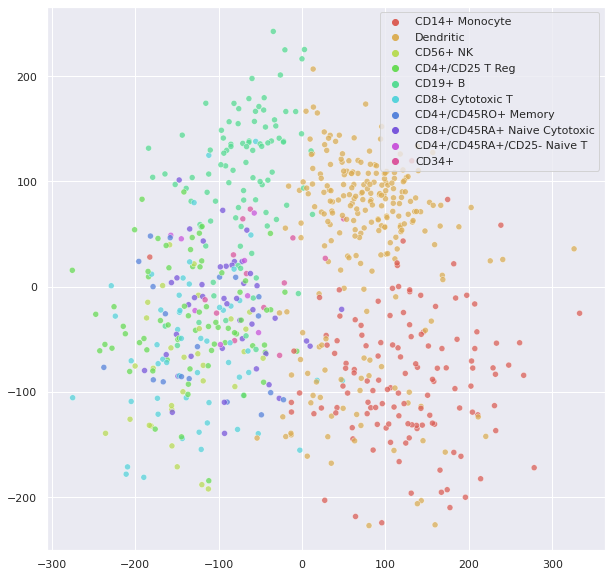

In [19]:
_, _, _, X_vae_best = vae_best.predict(X)

X_vae_best_pca = PCA(n_components=2).fit_transform(X_vae_best)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    x=X_vae_best_pca[:,0], y=X_vae_best_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", len(unique_labels)),
    legend='full',
    alpha=0.75
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_labels, loc='upper right');

##### 1.3.4.2: Autoencoder on different parameters

In [20]:
# Autoencoder latent space + PCA on different parameters
vae_alt = Autoencoder(num_genes, latent_dim=8, beta=0.0001)
vae_alt.compile(optimizer='adam')
vae_alt.fit(X, batch_size=70, epochs=100, verbose=0);

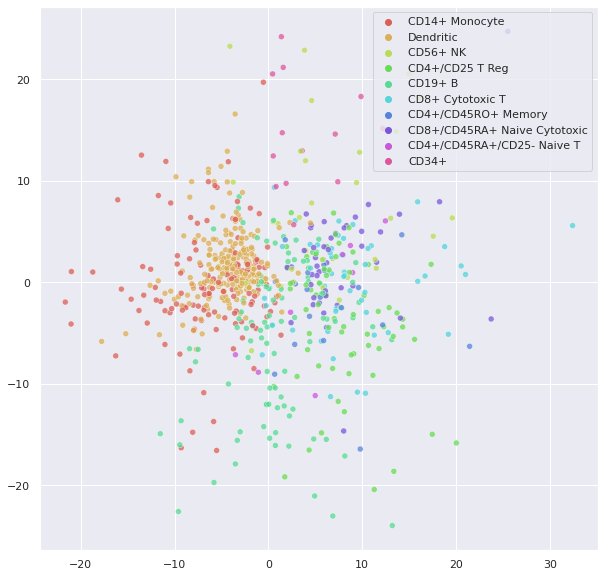

In [21]:
_, _, _, X_vae_alt = vae_alt.predict(X)

X_vae_alt_pca = PCA(n_components=2).fit_transform(X_vae_alt)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    x=X_vae_alt_pca[:,0], y=X_vae_alt_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", len(unique_labels)),
    legend='full',
    alpha=0.75
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_labels, loc='upper right');

##### 1.3.4.3: Autoencoder on 2-dimensions

In [22]:
# Autoencoder with 2-dimensional latent space
vae_small = Autoencoder(num_genes, latent_dim=2, beta=0.001)
vae_small.compile(optimizer='adam')
vae_small.fit(X, batch_size=70, epochs=100, verbose=0);

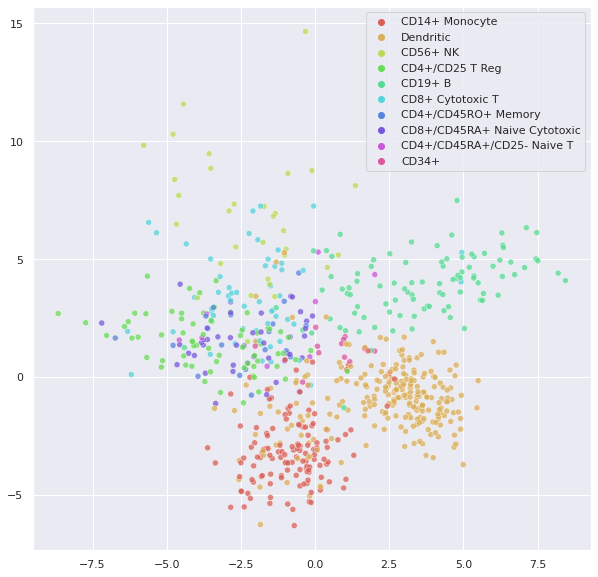

In [23]:
_, _, _, X_vae_small = vae_small.predict(X)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    x=X_vae_small[:,0], y=X_vae_small[:,1],
    hue=y,
    palette=sns.color_palette("hls", len(unique_labels)),
    legend='full',
    alpha=0.75
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_labels, loc='upper right');

##### 1.3.4.4: Writeup
While PCA and tSNE seem to lead to better separation (clearer clusters) in the data qualitatvely, we see that the autoencoder performs favorably compared to the two and seems to outperform random projection methods. For downstream analysis such as $k$-means clustering or classification, PCA and tSNE appear to be the superior methods. However, there is still value in the autoencoder. Since the variational autoencoder is a generative model, unlike PCA and tSNE, it can be used for tasks such as synthetic datasets, imputation, etc. Much like tSNE, we can also adjust the parameters in our model to get different types of clusters in our projection (namely, by changing the value of $\beta$).

## Part 2: Classifier

In this section of the project, we try out the following classifiers and report on their validation accuracy:
- Single decision tree
- Random forest
- AdaBoost on shallow decision trees
- Support vector machines
- Multinomial naive Bayes
- Complement naive Bayes
- Logistic regression
- Out-of-the-box MLP
- Custom MLP

### 2.1: Decision trees

#### 2.1.1: Single large decision tree

In [24]:
single_tree = DecisionTreeClassifier(criterion='entropy');
single_tree.fit(X_train, y_train);

In [25]:
single_tree_score = single_tree.score(X_val, y_val)
single_tree_table = ['Decision tree', single_tree_score]
print("Validation accuracy of a single decision tree: {}".format(single_tree_score))

Validation accuracy of a single decision tree: 0.6785714285714286


A single decision tree provides a good baseline for validation accuracy. We see that for this model, the accuracy is quite poor.

#### 2.1.2: Random forest

In [26]:
random_forest = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=8)
random_forest.fit(X_train, y_train);

In [27]:
random_forest_score = random_forest.score(X_val, y_val)
random_forest_table = ['Random forest', random_forest_score]
print("Validation accuracy of a random forest: {}".format(random_forest_score))

Validation accuracy of a random forest: 0.7928571428571428


When we introduce some bagging and randomization, we can improve the accuracy by quite a bit, almost reaching our threshold of 0.80.

#### 2.1.3: AdaBoost with shallow decision trees

In [28]:
base_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
boosted_forest = AdaBoostClassifier(base_estimator=base_tree, n_estimators=1000, random_state=145);
boosted_forest.fit(X_train, y_train);

In [29]:
boosted_forest_score = boosted_forest.score(X_val, y_val)
boosted_forest_table = ['AdaBoost w/ shallow decision trees', boosted_forest_score]
print("Validation accuracy of a boosted forest: {}".format(boosted_forest_score))

Validation accuracy of a boosted forest: 0.8


Taking this further with boosting, we see that once again we are very close to our threshold. However, it might be the case that the model is overfitting, or that decision trees are not well suited for our data. 

### 2.2: Support vector machines

In [30]:
base_svm = SVC(C=0.01, kernel='linear')
svms = OneVsRestClassifier(base_svm);
svms.fit(X_train, y_train);

In [31]:
svms_score = svms.score(X_val, y_val)
svms_table = ['SVMs', svms_score]
print("Validation accuracy of multiple SVMSs: {}".format(svms_score))

Validation accuracy of multiple SVMSs: 0.8714285714285714


SVMs seem to work suprisingly well on our data, suggesting that linear boundaries are well-suited in this context.

### 2.3: Naive Bayes

We can also attempt to model the data in a more probabilistic manner, which yields decent results.

In [32]:
X_train_shifted = X_train - np.min(X_train, axis=0)
mt_bayes = MultinomialNB(alpha=10)
mt_bayes.fit(X_train_shifted, y_train);

In [33]:
X_val_shifted = X_val - np.min(X_val, axis=0)
mt_bayes_score = mt_bayes.score(X_val_shifted, y_val)
mt_bayes_table = ['Multinomial Bayes', mt_bayes_score]
print("Validation accuracy of multinomial naive Bayes: {}".format(mt_bayes_score))

Validation accuracy of multinomial naive Bayes: 0.8285714285714286


In [34]:
comp_bayes = ComplementNB(alpha=1)
comp_bayes.fit(X_train_shifted, y_train);

In [35]:
comp_bayes_score = comp_bayes.score(X_val_shifted, y_val)
comp_bayes_table = ['Complement Bayes', comp_bayes_score]
print("Validation accuracy of complement naive Bayes: {}".format(comp_bayes_score))

Validation accuracy of complement naive Bayes: 0.8


### 2.4: Logistic regression

In [36]:
base_logistic = LogisticRegression(C=100, multi_class='multinomial')
logistics = OneVsRestClassifier(base_logistic)
logistics.fit(X_train, y_train);

In [37]:
logistics_score = logistics.score(X_val, y_val)
logistics_table = ['Logistic regression', logistics_score]
print("Validation accuracy of logistic regression: {}".format(logistics_score))

Validation accuracy of logistic regression: 0.8642857142857143


We see that logistic regression has good validation accuracy, once again suggesting that the decision boundaries roughly linear. 

### 2.5: Neural network

In [38]:
# Check that we are using GPU for the runtime
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


#### 2.5.1: Out-of-the-box MLP

In [39]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train);

In [40]:
ootb_mlp_score = mlp.score(X_val, y_val)
ootb_mlp_table = ['Out-of-the-box MLP', ootb_mlp_score]
print("Validation accuracy of an out-of-the-box MLP: {}".format(ootb_mlp_score))

Validation accuracy of an out-of-the-box MLP: 0.8142857142857143


An out-of-the-box seems to work well, but not as well as other, simpler methods such as SVMs or logistic regression. This might be due to overfitting due to the parameters in neural networks. Maybe we can achieve better accuracy with a custom MLP. 

#### 2.5.2: Custom MLP

In [68]:
# One-hot encoding
num_cats = len(unique_labels)
y_hot = np.zeros((num_samples, num_cats))
for i in range(num_samples):
    y_hot[i, y[i]] = 1

In [69]:
# Train/test split
X_train, X_test, y_train, y_test = split(X, y_hot, test_size=0.2, random_state=145)

In [100]:
clf = keras.Sequential([layers.Input(shape=(num_genes,))])

clf.add(layers.GaussianNoise(1))

clf.add(layers.Dense(512, activation='relu', activity_regularizer=keras.regularizers.L2(l2=0.001)))
clf.add(layers.Dropout(rate=0.4))

clf.add(layers.Dense(128, activation='relu', activity_regularizer=keras.regularizers.L2(l2=0.001)))
clf.add(layers.Dropout(rate=0.3))

clf.add(layers.Dense(32, activation='relu'))

clf.add(layers.Dense(num_cats, activation='softmax'))

In [101]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
clf.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='categorical_accuracy')

In [104]:
num_epochs = 50
clf.fit(X_train, y_train, batch_size=70, epochs=num_epochs, verbose=0);

In [105]:
custom_mlp_score = clf.evaluate(X_test, y_test)[1]
custom_mlp_table = ['Custom MLP', custom_mlp_score]
print("Validation accuracy of custom MLP: {}".format(custom_mlp_score))

5/5 [==============================] - 0s 3ms/step - loss: 0.8395 - categorical_accuracy: 0.8286
Validation accuracy of custom MLP: 0.8285714387893677


### 2.6: Summary of classifiers + writeup

In [106]:
data = [
        single_tree_table,
        random_forest_table,
        boosted_forest_table,
        svms_table,
        mt_bayes_table,
        comp_bayes_table,
        logistics_table,
        ootb_mlp_table,
        custom_mlp_table
]
header = ["Model", "Validation accuracy"]
print(tabulate(data, headers=header))

Model                                 Validation accuracy
----------------------------------  ---------------------
Decision tree                                    0.678571
Random forest                                    0.792857
AdaBoost w/ shallow decision trees               0.8
SVMs                                             0.871429
Multinomial Bayes                                0.828571
Complement Bayes                                 0.8
Logistic regression                              0.864286
Out-of-the-box MLP                               0.814286
Custom MLP                                       0.828571


Therefore, the classifier of choice is the support vector machine with linear kernel. One possible reason as to why this classifier works well is because the data is inherently linearly separable. Recalling the visualizations in 0.2, we notice that many of the gene counts congregate towards 0, while a couple have higher values. In other words, the data is naturally sparse. This means that we can draw a threshold value for each gene count to divide those cells with no expression of the gene and those with high expression. Because of this, a clasifier with linear decision boundaries is a good fit. This idea is further supported by the high validation accuracy of logistic regression, which can also find linear decision boundaries. On the other hand, methods such as decision trees and naive Bayes do not necessarily find a linear hypothesis.